# Overview
As we saw in the last notebook, spaCy doesn't work great for clinical text out of the box. We're interested in extracting different types of information from clinical text than news or Wikipedia articles. Clinical text is also very different from general domain language. 
- **It is very messy**, with semi-structured formatting from EHR
- Clinical documents include **many abbreviations**, some of which are ambiguous
- There are **specific tasks** needed in clinical NLP, such as **detecting negation or uncertainty** for concepts in the text

One of the most powerful components of spaCy is that is **very customizable**. In addition to working with the default models provided in the core library, you can create your own [custom components](https://spacy.io/usage/processing-pipelines#custom-components) or add your own [extension attributes](https://spacy.io/usage/processing-pipelines#custom-components-attributes). Developers and researchers can then publish their spaCy extensions to the open-source community. Some examples of these openly available libraries are:

- [scispacy](https://allenai.github.io/scispacy/): Includes models trained on biomedical literature
- [medCAT](https://github.com/CogStack/MedCAT): Models trained for medical concept extraction

In the next two notebooks, we'll use [medspacy](https://github.com/medspacy/medspacy), a newly released package for performing clinical NLP tasks in spaCy. 

# medspacy
<img alt="MedSpaCy logo" src="https://github.com/medspacy/medspacy/raw/master/images/medspacy_logo.png">


[Medspacy](https://github.com/medspacy/medspacy) is an open-source package maintained by NLP developers at the University of Utah and the US Department of Veterans Affairs. The goal of medSpaCy is to provide flexible, easy-to-use spaCy components for common clinical NLP tasks, such as:

- Concept extraction
- Negation detection
- Document section splitting

One of the early uses of medSpaCy includes a [biosurveillance system for identifying positive cases of COVID-19](https://openreview.net/forum?id=ZQ_HvBxcdCv).

**MedSpaCy is still in beta**, and you are one of the first users!

# How to complete this notebook

## YouTube Links
Throughout this notebook, we'll provide links to Dr. Wendy Chapman's talk [**"Developing Clinical Natural Language Processing System"**](https://youtu.be/UEm7H8cfz80), where she talks about the challenges in clinical NLP and how we can overcome them. We'll then put those ideas into context processing examples of clinical text with medSpaCy.

## TODO Exercises
Some cells will be marked with **TODO**. Whenever you see this, you'll be asked to complete the following code. Some of the code will be partially completed with `___` as "fill-in-the-blank" placeholders. For example, if you see:

---
### TODO
Change the code below to print out **"Hello, world!"**
```python
print(___)
```
---
You should chage the code to:
```python
print("Hello, world!")
```

# I. Getting started with medSpaCy
Let's get started with medSpaCy. Just like with spaCy, we'll load a model containing a processing pipeline. Unlike the typical spaCy models, this pipeline will include some additional components for specific clinical tasks.

In [1]:
from IPython.display import YouTubeVideo

In [2]:
import spacy
import medspacy

In [ ]:
nlp = medspacy.load()

In [ ]:
nlp.pipe_names

For data, we'll use these short example texts:

In [ ]:
texts = [
    "Patient presents for management of Type II Diabetes Mellitus",
    "No evidence of pneumonia",
    "Past medical history significant for afib, CHF, and CKD Stage 3, now CKD stage five.",
    "Mother with breast cancer",
    "continue metformin for type 2 dm",
    "Her grandma was recently diagnosed with Alzheimer's"
]

### Discussion
What information would be useful to extract from these texts? What processing steps do you need to take?

# II. Concept extraction
The first step we'll take is to define the **target concepts** we're interested in. In the previous notebook, spaCy extracted concepts like **"PERSON"** and **"ORG"**. In this notebook, we'll extract the following labels:
- **"PROBLEM"**
- **"TREATMENT"**
- **"TEST"**

We'll start by building a **rule-based system**. In rule-based NLP, we define patterns to match concepts in text. SpaCy offers many [rule-based methods](https://spacy.io/usage/rule-based-matching). MedSpaCy uses a pipeline component called `TargetMatcher` and rules defined by a class called `TargetRule`. Extracted concepts will be stored as `Span` objects in `doc.ents`.

We can access the target matcher through the `get_pipe()` method:

In [ ]:
target_matcher = nlp.get_pipe("target_matcher")
target_matcher

In [ ]:
# Import class for defining rules
from medspacy.ner import TargetRule

Target rules require two positional arguments:
- `literal`: A span of text to match in the text (case insensitive)
- `category`: The label to assign to extracted concepts

Let's define rules to extract any relevant clinical concepts in the texts above.


In [ ]:
target_rules = [
    TargetRule("pneumonia", "PROBLEM"),
    TargetRule("afib", "PROBLEM"),
    TargetRule("CHF", "PROBLEM"),
    TargetRule("Breast Cancer", "PROBLEM"),
    TargetRule("Alzheimer's", "PROBLEM"),
    TargetRule("metformin", "TREATMENT"),
]

We then add these rules to our target matcher:

In [ ]:
target_matcher.add(target_rules)

The simplest form of string-matching in spaCy is just exact strings to match, as shown above. However, we can also add more complex patterns to match concepts with varying form. For example, the same or similar concepts can be mentioned in multiple formats:
- **"Type II Diabetes Mellitus"** and **"type 2 dm"**
- **"CKD Stage 3"** and **"CKD Stage Five"**

We can write more complex rules using token attributes to match multiple string formats at once. A pattern is a list of dictionaries representing conditions to match on each token. See SpaCy's documentation on [rule-based matching](https://spacy.io/usage/rule-based-matching) for more information on how these patterns work.

In [ ]:
target_rules2 = [
    TargetRule("CKD", "PROBLEM", pattern=[
        {"LOWER": "ckd"}, # Token 1
        {"LOWER": "stage"}, # Token 2
        {"LIKE_NUM": True} # Token 3
        ]),
    
    TargetRule("Type II Diabetes Mellitus", "PROBLEM", 
              pattern=[
                  {"LOWER": "type"},
                  {"LOWER": {"IN": ["2", "ii", "two"]}},
                  {"LOWER": {"IN": ["dm", "diabetes"]}},
                  {"LOWER": "mellitus", "OP": "?"}
              ]),
]

In [ ]:
target_matcher.add(target_rules2)

Now we can process the texts by calling `nlp.pipe(texts)`:

In [ ]:
docs = list(nlp.pipe(texts))

Let's visualize the entities extracted in these docs.

In [ ]:
from spacy import displacy

In [ ]:
displacy.render(docs, style="ent")

### TODO 
Add rules to extract any problems, treatments, or tests in the text below. Add it to the target matcher and process the text.

In [ ]:
text = """Patient presents to emergency department with complaint of SOB, cough and chills.
Ordered a respiratory panel to test for SARS-COV-2. 

Patient has an allergy to penicillin.
"""

In [ ]:
new_target_rules = [
    TargetRule(____, "PROBLEM"),
    TargetRule(____, ____),
    # ...
]

In [ ]:
target_matcher.add(new_target_rules)

In [ ]:
doc = nlp(text)

In [ ]:
displacy.render(doc, style="ent")

### What makes named entity recognition difficult in clinical texts?

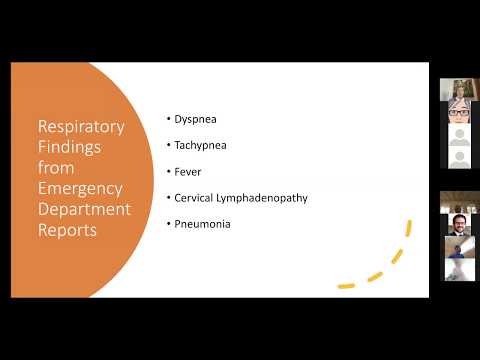

In [3]:
YouTubeVideo("UEm7H8cfz80", start=1638, end=1735, rel=0)

# Next Steps
Now that we know how to extract clinical concepts from texts, we'll next look at why we need to analyze the context around extracted entities and how that helps inform us in our text processing.

[nlp-03-context-section-detection.ipynb](nlp-03-context-section-detection.ipynb)